David Bailey

CSCI E-63

Final Project

# Constructing a Knowledge Graph With Genetic Data

This script demonstrates how to construct a Neo4j knowledge graph using disease-disease associations as well as gene-disease associations datasets and how to perform queries using both Neo4j and Pyspark. Data was first explored using pandas and numpy. The two datasets were then merged using temp views and Pyspark SQL, and the knowledge graph was constructed using the Neo4j cypher-shell load csv command. Neo4j queries were performed on both the browser (for visualizations) and the cypher-shell (for table results). Finally, the graph was read in as a Pyspark dataframe to demonstrate how to perform similar queries using Spark.

## Importing Libraries

In [1]:
# Pyspark libraries:
from pyspark import *
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.functions import struct
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
from pyspark.sql.functions import expr

# To ignore warnings:
import warnings
warnings.filterwarnings("ignore")

# Set log level to error:
sc.setLogLevel('ERROR')

# Import os for file pathways:
import os

# Import pandas for final processing:
import pandas as pd
import numpy as np

# Import to display images:
from IPython.display import display, Image

## Exploratory Data Analysis of Chosen Data

Data was downloaded from the following link: 

https://www.disgenet.org/downloads

I chose the gene-association dataset with the purposes of joining it with the disease-association sets on disease name so that I could examine which genes specifically two diseases may both be associated with. I will do so by using pyspark sql to convert the data into the proper form to load as a neo4j graph database. This will allow me to learn more about what genes diseases have in common through both SQL and CQL queries. 

### Reading In Original Datasets

In [3]:
df1 = pd.read_csv(os.path.join('..', 'data', 'all_gene_disease_associations.tsv'), sep='\t')

In [5]:
df2 = pd.read_csv(os.path.join('..', 'data', 'disease_to_disease_ALL.tsv'), sep='\t')

### Summary Statistics of Gene-Disease Association Dataset

We will first examine the gene-disease association dataset.

In [4]:
df1.shape

(1134942, 16)

In [5]:
df1.head()

,geneId,geneSymbol,DSI,DPI,diseaseId,diseaseName,diseaseType,diseaseClass,diseaseSemanticType,score,EI,YearInitial,YearFinal,NofPmids,NofSnps,source
0,1,A1BG,0.7,0.538,C0001418,Adenocarcinoma,group,C04,Neoplastic Process,0.01,1.0,2008.0,2008.0,1,0,LHGDN
1,1,A1BG,0.7,0.538,C0002736,Amyotrophic Lateral Sclerosis,disease,C18;C10,Disease or Syndrome,0.01,1.0,2008.0,2008.0,1,0,BEFREE
2,1,A1BG,0.7,0.538,C0003578,Apnea,phenotype,C23;C08,Sign or Symptom,0.01,1.0,2017.0,2017.0,1,0,BEFREE
3,1,A1BG,0.7,0.538,C0003864,Arthritis,disease,C05,Disease or Syndrome,0.01,1.0,2019.0,2019.0,1,0,BEFREE
4,1,A1BG,0.7,0.538,C0008373,Cholesteatoma,disease,C17,Disease or Syndrome,0.01,1.0,2020.0,2020.0,1,0,BEFREE


We see there are over 1 million rows of data and 16 columns. We will next examine the number of disease names, number of disease types, and number of genes represented in the dataset:

In [10]:
n_genes = len(np.unique(df1['geneSymbol']))
n_disease_names = len(np.unique(df1['diseaseName']))
n_disease_types = len(np.unique(df1['diseaseType']))

In [11]:
print(f'There are {n_genes} unique genes in this dataset.')
print(f'There are {n_disease_names} diseases of {n_disease_types} types in this dataset.')

There are 21666 unique genes in this dataset.
There are 30170 diseases of 3 types in this dataset.


In [12]:
disease_types = np.unique(df1['diseaseType'])
print(f'Types of disease in dataset: {disease_types}')

Types of disease in dataset: ['disease' 'group' 'phenotype']


We can see there are quite a large number of unique genes and unique diseases in the dataset. However, the diseases fall into only three types. Let's next check for missing values:

In [13]:
df1.isnull().sum()

geneId                      0
geneSymbol                  0
DSI                      2584
DPI                      2882
diseaseId                   0
diseaseName                 0
diseaseType                 0
diseaseClass           156403
diseaseSemanticType         0
score                       0
EI                     166974
YearInitial            166974
YearFinal              166974
NofPmids                    0
NofSnps                     0
source                      0
dtype: int64

There are quite a few missing values for certain columns. However, this project will be focusing on geneSymbol and diseaseName in particular. For those columns, we see that no values are missing. We can then move on to the next dataset:

### Disease-Disease Association Dataset

In [14]:
df2.shape

(63680896, 15)

In [15]:
df2.head()

,diseaseId2,diseaseId1,source,Ngenes,NgenesD1,NgenesD2,union_genes,jaccard_genes,Nvariants,NvariantsD1,NvariantsD2,union_variant,jaccard_variant,diseaseId1_name,diseaseId2_name
0,C0000727,C0000737,ALL,1,302,2,303,0.003300,0,0,0,0,0.0,Abdominal Pain,"Abdomen, Acute"
1,C0000727,C0001144,ALL,1,94,2,95,0.010526,0,0,0,0,0.0,Acne Vulgaris,"Abdomen, Acute"
2,C0000727,C0001339,ALL,1,435,2,436,0.002294,0,0,0,0,0.0,Acute pancreatitis,"Abdomen, Acute"
3,C0000727,C0001416,ALL,1,9,2,10,0.100000,0,0,0,0,0.0,Adenitis,"Abdomen, Acute"
4,C0000727,C0002395,ALL,1,3397,2,3398,0.000294,0,0,0,0,0.0,Alzheimer's Disease,"Abdomen, Acute"


In [16]:
df2.isnull().sum()

diseaseId2         0
diseaseId1         0
source             0
Ngenes             0
NgenesD1           0
NgenesD2           0
union_genes        0
jaccard_genes      0
Nvariants          0
NvariantsD1        0
NvariantsD2        0
union_variant      0
jaccard_variant    0
diseaseId1_name    0
diseaseId2_name    0
dtype: int64

In [17]:
n_disease1_names = len(np.unique(df2['diseaseId1_name']))
n_disease2_names = len(np.unique(df2['diseaseId2_name']))

print(f'There are {n_disease1_names} unique diseases from set 1.')
print(f'There are {n_disease2_names} unique diseases from set 2.')

There are 30264 unique diseases from set 1.
There are 30264 unique diseases from set 2.


Here, we have a much larger number of observations, with over 63 million and with no missing values in any column. We have disease names, which we can use to join with the gene-association dataset so that we can relate two different diseases by the exact gene they share an association with. Further, we have an equivalent number of unique diseases in both datasets, with 30264 unique diseases in each.

## Knowledge Graph Data Preparation Based on EDA

Based on the exploratory data analysis, the dataset did not need to be heavily processed, but I did need to sample to reduce computational demands, and I also needed to join the datasets. I did so by viewing the gene-association dataset as vertices and the disease-association dataset as edges, with the disease names in the gene-association dataset being analogous to the 'id' column and the disease 1 and disease 2 names in the disease-association dataset being analogous to 'src' and 'dst', respectively. As such, I renamed columns and named variables according to that naming convention, even though I did not use a graph frame in the end.

### Launching Pyspark

Pyspark was launched from the terminal using the following arguments from the directory in which the data and script files exist:

In [ ]:
(base) davidbailey@Davids-MBP / % cd usr/local/Cellar/apache-spark/3.2.1/libexec/jars 
(base) davidbailey@Davids-MBP jars % scp ~/Downloads/neo4j-connector-apache-spark_2.12-4.1.2_for_spark_3.jar 
neo4j-connector-apache-spark_2.12-4.1.2_for_spark_3.jar

In [ ]:
(base) davidbailey@Davids-MBP ~ % cd Documents/github/63/final 
(base) davidbailey@Davids-MBP final % export PYSPARK_DRIVER_PYTHON=jupyter
(base) davidbailey@Davids-MBP final % export PYSPARK_DRIVER_PYTHON_OPTS='notebook'
(base) davidbailey@Davids-MBP final % pyspark --driver-memory 15G 
--jars neo4j-connector-apache-spark_2.12-4.1.2_for_spark_3.jar

### Reading in Spark Dataframes

In [18]:
# Read in gene-association data as vertices:
vertices = spark.read.option('sep', '\t').csv(os.path.join('..', 'data', 'all_gene_disease_associations.tsv'), 
                                              header=True)\
.withColumnRenamed('diseaseName', 'id')

# Read in disease-association data as edges:
edges = spark.read.option('sep', '\t').csv(os.path.join('..', 'data', 'disease_to_disease_ALL.tsv'), header=True)\
.withColumnRenamed('diseaseId1_name', 'src').withColumnRenamed('diseaseId2_name', 'dst')

### Taking Random Samples of Datasets Using Spark SQL

I chose to create temp views and query random samples of each dataset. Because I will ultimately join the two datasets to include the gene association that diseases share, I also filtered the disease association (edges) dataset to include only disease 1 names and disease 2 names that appear in the gene-association (vertices) dataset.

In [19]:
# Create temp view for vertices:
vertices.createOrReplaceTempView("v")

In [20]:
# Random sample query of vertices:
v_sub_query = "SELECT * FROM v \
ORDER BY RAND(63) \
LIMIT 10000"
vertices = spark.sql(v_sub_query).distinct()

In [21]:
# Use vertices subset as new temp view:
vertices.createOrReplaceTempView("v_sub")

# Create temp view of edges:
edges.createOrReplaceTempView("e")

In [22]:
# Filter src and dst values that appear in vertices subset, then randomly sample 100k values from edges:
e_sub_query = "SELECT * FROM e \
WHERE src IN (SELECT DISTINCT(id) FROM v_sub) \
AND dst IN (SELECT DISTINCT(id) FROM v_sub) \
ORDER BY RAND(63) \
LIMIT 100000"

edges = spark.sql(e_sub_query)

### Joining Datasets

I next used a series of queries, starting with the src column then the dst column, to merge the gene symbols with the association disease 1 names and disease 2 names. I then joined the src and dst datasets to create a graph dataframe.

In [23]:
# Create temp view of edges subset:
edges.createOrReplaceTempView("e_sub")

In [24]:
# Inner join srcs with vertices IDs:
srcs_query = "SELECT * FROM e_sub \
INNER JOIN v_sub ON e_sub.src = v_sub.id"

srcs = spark.sql(srcs_query).withColumnRenamed('geneSymbol', 'geneSymbolSrc')\
.withColumnRenamed('src', 'srcSrc')

In [25]:
# Inner join dsts with vertices IDs:
dsts_query = "SELECT * FROM e_sub \
INNER JOIN v_sub ON e_sub.dst = v_sub.id"

dsts = spark.sql(dsts_query).withColumnRenamed('geneSymbol', 'geneSymbolDst')\
.withColumnRenamed('dst', 'dstDst')

In [26]:
# Create temp view of srcs and dsts:
srcs.createOrReplaceTempView("srcs")
dsts.createOrReplaceTempView("dsts")

In [27]:
# Join on gene symbol:
src_dst_join_query = "SELECT * FROM srcs \
LEFT JOIN dsts ON srcs.geneSymbolSrc = dsts.geneSymbolDst"

src_dst = spark.sql(src_dst_join_query)

In [28]:
# Create temp view of joined dataset:
src_dst.createOrReplaceTempView("src_dst")

In [29]:
# Remove instances where src = dst:
graph_query = "SELECT * FROM src_dst \
WHERE geneSymbolSrc = geneSymbolDst \
AND srcSrc != dstDst"

graph = spark.sql(graph_query)

In [30]:
# Select and rename relevant columns:
graph = graph.select(['srcSrc', 'geneSymbolSrc', 'dstDst']).dropDuplicates()\
.withColumnRenamed('geneSymbolSrc', 'geneSymbol').withColumnRenamed('srcSrc', 'src')\
.withColumnRenamed('dstDst', 'dst').drop('srcDst', 'dstSrc')

In [31]:
# Pring number of rows:
print(f'Number of rows in unprocessed graph dataframe: {graph.count()}')

Number of rows in unprocessed graph dataframe: 22853


In [32]:
# Display first five rows:
graph.show(5)

+--------------------+----------+--------------------+
|                 src|geneSymbol|                 dst|
+--------------------+----------+--------------------+
|Benign Prostatic ...|     ABCA1|Alzheimer disease...|
|Benign Prostatic ...|     ABCA1|Gestational Diabetes|
|Alzheimer disease...|     ABCA1|Benign Prostatic ...|
|Alzheimer disease...|     ABCA1|Gestational Diabetes|
|Gestational Diabetes|     ABCA1|Benign Prostatic ...|
+--------------------+----------+--------------------+
only showing top 5 rows



### Final processing with Spark and Pandas

Because the direction of the relationship doesn't matter, there were duplicates in the dataset whenever the same src, dst pair appeared in reverse. To remove such instances from the dataset, I created a paired struct column in Pyspark. Then, after converting to a Pandas dataframe but before saving the final dataframe as a CSV file, I sorted the src, dst pairs by alphabetical order and converted them to tuples to drop duplicates.

In [33]:
# Create struct column that pairs src and dst row values:
graph = graph.withColumn("src_dst", struct(graph.src, graph.dst))

In [34]:
# Display first five rows:
graph.show(5)

+--------------------+----------+--------------------+--------------------+
|                 src|geneSymbol|                 dst|             src_dst|
+--------------------+----------+--------------------+--------------------+
|Benign Prostatic ...|     ABCA1|Alzheimer disease...|{Benign Prostatic...|
|Benign Prostatic ...|     ABCA1|Gestational Diabetes|{Benign Prostatic...|
|Alzheimer disease...|     ABCA1|Benign Prostatic ...|{Alzheimer diseas...|
|Alzheimer disease...|     ABCA1|Gestational Diabetes|{Alzheimer diseas...|
|Gestational Diabetes|     ABCA1|Benign Prostatic ...|{Gestational Diab...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows



In [35]:
# Convert to pandas df:
graph_pdf = graph.toPandas()

In [36]:
# Display shape:
graph_pdf.shape

(22853, 4)

In [37]:
# Display first five rows:
graph_pdf.head()

,src,geneSymbol,dst,src_dst
0,Benign Prostatic Hyperplasia,ABCA1,"Alzheimer disease, familial, type 3","(Benign Prostatic Hyperplasia, Alzheimer disea..."
1,Benign Prostatic Hyperplasia,ABCA1,Gestational Diabetes,"(Benign Prostatic Hyperplasia, Gestational Dia..."
2,"Alzheimer disease, familial, type 3",ABCA1,Benign Prostatic Hyperplasia,"(Alzheimer disease, familial, type 3, Benign P..."
3,"Alzheimer disease, familial, type 3",ABCA1,Gestational Diabetes,"(Alzheimer disease, familial, type 3, Gestatio..."
4,Gestational Diabetes,ABCA1,Benign Prostatic Hyperplasia,"(Gestational Diabetes, Benign Prostatic Hyperp..."


In [38]:
# Convert src_dst column to sorted tuples:
graph_pdf['src_dst'] = graph_pdf['src_dst'].apply(lambda x: tuple(sorted(x)))

In [39]:
# Verify results:
graph_pdf.head()

,src,geneSymbol,dst,src_dst
0,Benign Prostatic Hyperplasia,ABCA1,"Alzheimer disease, familial, type 3","(Alzheimer disease, familial, type 3, Benign P..."
1,Benign Prostatic Hyperplasia,ABCA1,Gestational Diabetes,"(Benign Prostatic Hyperplasia, Gestational Dia..."
2,"Alzheimer disease, familial, type 3",ABCA1,Benign Prostatic Hyperplasia,"(Alzheimer disease, familial, type 3, Benign P..."
3,"Alzheimer disease, familial, type 3",ABCA1,Gestational Diabetes,"(Alzheimer disease, familial, type 3, Gestatio..."
4,Gestational Diabetes,ABCA1,Benign Prostatic Hyperplasia,"(Benign Prostatic Hyperplasia, Gestational Dia..."


In [40]:
# Drop duplicate relationships:
subset_cols = ['geneSymbol', 'src_dst']
graph_pdf.drop_duplicates(subset=subset_cols, inplace=True)

In [41]:
# Verify new shape:
graph_pdf.shape

(11447, 4)

In [43]:
# Rename columns and drop src_dst:
graph_pdf.rename(columns={'src': 'disease1', 'dst': 'disease2'}, inplace=True)
graph_pdf.drop(['src_dst'], axis=1, inplace=True)

In [44]:
# Verify results:
graph_pdf.head()

,disease1,geneSymbol,disease2
0,Benign Prostatic Hyperplasia,ABCA1,"Alzheimer disease, familial, type 3"
1,Benign Prostatic Hyperplasia,ABCA1,Gestational Diabetes
3,"Alzheimer disease, familial, type 3",ABCA1,Gestational Diabetes
6,Tachypnea,ABCA3,"Respiratory Distress Syndrome, Adult"
8,Adrenoleukodystrophy,ABCA4,Oral cleft


In [45]:
# Print new number of rows:
print(f'Number of rows in processed graph dataframe: {len(graph_pdf)}')

Number of rows in processed graph dataframe: 11447


In [46]:
# Save results as csv:
graph_pdf.to_csv(os.path.join('..', 'data', 'disease_gene_graph.csv'), index=False)

### Loading Data as Neo4j Database

With the graph data prepared, I loaded it to a Neo4j database from the terminal. To do so, I copied the saved CSV file to the import folder within the neo4j directory, and I renamed the default database within the neo4j.conf file within the neo4j conf directory to "diseases." I then performed the query below, which resulted in 4638 nodes, 11447 relationships, 16085 properties, and 4638 labels.

In [ ]:
(base) davidbailey@Davids-MBP Documents % cd neo4j 
(base) davidbailey@Davids-MBP neo4j % ls
neo4j-community-4.4.5			neo4j-community-4.4.5-unix.tar.gz
(base) davidbailey@Davids-MBP neo4j % cd neo4j-community-4.4.5
(base) davidbailey@Davids-MBP neo4j-community-4.4.5 % ls
LICENSE.txt	UPGRADE.txt	data		licenses
LICENSES.txt	bin		import		logs
NOTICE.txt	certificates	labs		plugins
README.txt	conf		lib		run
(base) davidbailey@Davids-MBP neo4j-community-4.4.5 % cd bin
(base) davidbailey@Davids-MBP bin % cd ../conf
(base) davidbailey@Davids-MBP conf % ls
neo4j.conf
(base) davidbailey@Davids-MBP conf % vi neo4j.conf
(base) davidbailey@Davids-MBP conf % ../bin

(base) davidbailey@Davids-MBP bin % ./cypher-shell -u neo4j -p ***** -d diseases
Connected to Neo4j using Bolt protocol version 4.4 at neo4j://localhost:7687 as user neo4j.
Type :help for a list of available commands or :exit to exit the shell.
Note that Cypher queries must end with a semicolon.

neo4j@diseases> LOAD CSV WITH HEADERS FROM "file:///disease_gene_graph.csv" AS line
                MERGE (dis1:DISEASE1 {desc: line.disease1})
                MERGE (dis2:DISEASE2 {desc: line.disease2})
                MERGE (dis1)-[:SHARES_GENE_WITH {gene_symbol: line.geneSymbol}]-(dis2);
0 rows
ready to start consuming query after 9580 ms, results consumed after another 0 ms
Added 4638 nodes, Created 11447 relationships, Set 16085 properties, Added 4638 labels
neo4j@diseases> 

## Neo4j Queries and Visualizations

Now that the knowledge graph is constructed, we can perform queries and extract information in addition to visualizing the gene associations shared between different conditions.

### Querying Most Prevalent Conditions

I began with a simple query using cypher-shell to find the condiions that share the most gene associations with other diseases among all disease 1s.

In [ ]:
neo4j@diseases> MATCH (n:DISEASE1)-[r]-()
                RETURN n.desc AS disease_1, COUNT(r) AS n_associations 
                ORDER BY n_associations DESC 
                LIMIT 10;
+-------------------------------------------------------+
| disease_1                            | n_associations |
+-------------------------------------------------------+
| "Carcinoma of lung"                  | 86             |
| "Neoplasms"                          | 81             |
| "leukemia"                           | 67             |
| "Colon Carcinoma"                    | 63             |
| "Primary malignant neoplasm of lung" | 56             |
| "Tumor Cell Invasion"                | 51             |
| "Ischemic stroke"                    | 50             |
| "Atherosclerosis"                    | 49             |
| "Prostate carcinoma"                 | 46             |
| "Malignant Neoplasms"                | 45             |
+-------------------------------------------------------+

10 rows
ready to start consuming query after 5 ms, results consumed after another 11 ms

We can see that carcinoma of lung is the most prevalent disease, with is 86 gene associations with other conditions. I next queried how many distinct genes it shares with other conditions, as well as what exactly those genes are:

In [ ]:
neo4j@diseases> MATCH (n:DISEASE1)-[r]-() WHERE n.desc = 'Carcinoma of lung'
                RETURN COUNT(DISTINCT(r.gene_symbol));
+--------------------------------+
| COUNT(DISTINCT(r.gene_symbol)) |
+--------------------------------+
| 30                             |
+--------------------------------+

neo4j@diseases> MATCH (n:DISEASE1)-[r]-() WHERE n.desc = 'Carcinoma of lung'
                RETURN DISTINCT(r.gene_symbol) AS gene_symbol;
+--------------+
| gene_symbol  |
+--------------+
| "MICA"       |
| "CNTN1"      |
| "CALCA"      |
| "USP9X"      |
| "FOLH1"      |
| "CDH1"       |
| "CHEK2"      |
| "TBX1"       |
| "DCTN4"      |
| "CASP8"      |
| "CRMP1"      |
| "FLNA"       |
| "SSTR3"      |
| "NR3C1"      |
| "PECAM1"     |
| "ABCC8"      |
| "ACACA"      |
| "FYN"        |
| "ALPP"       |
| "CDKN2B-AS1" |
| "IL25"       |
| "EPC1"       |
| "LIN28A"     |
| "CELIAC2"    |
| "MARK2"      |
| "DPP4"       |
| "PDK1"       |
| "DUOX2"      |
| "SOX17"      |
| "RORA"       |
+--------------+

30 rows

There are 30 distinct genes that carcinoma of lung shares an association with among the other conditions. I then performed a query to return all the relationships where carcinoma of lung is disease1 in the neo4j browser to visualize the graph for carcinoma of lung and its 30 gene associations that it shares a total of 86 times with other conditions and saved the image to display (with the query that produced the image found in the cell above the image).

In [ ]:
# Query code used to generate image:
MATCH (n:DISEASE1)-[r]-() WHERE n.desc = 'Carcinoma of lung'
RETURN (n)-[r]-();

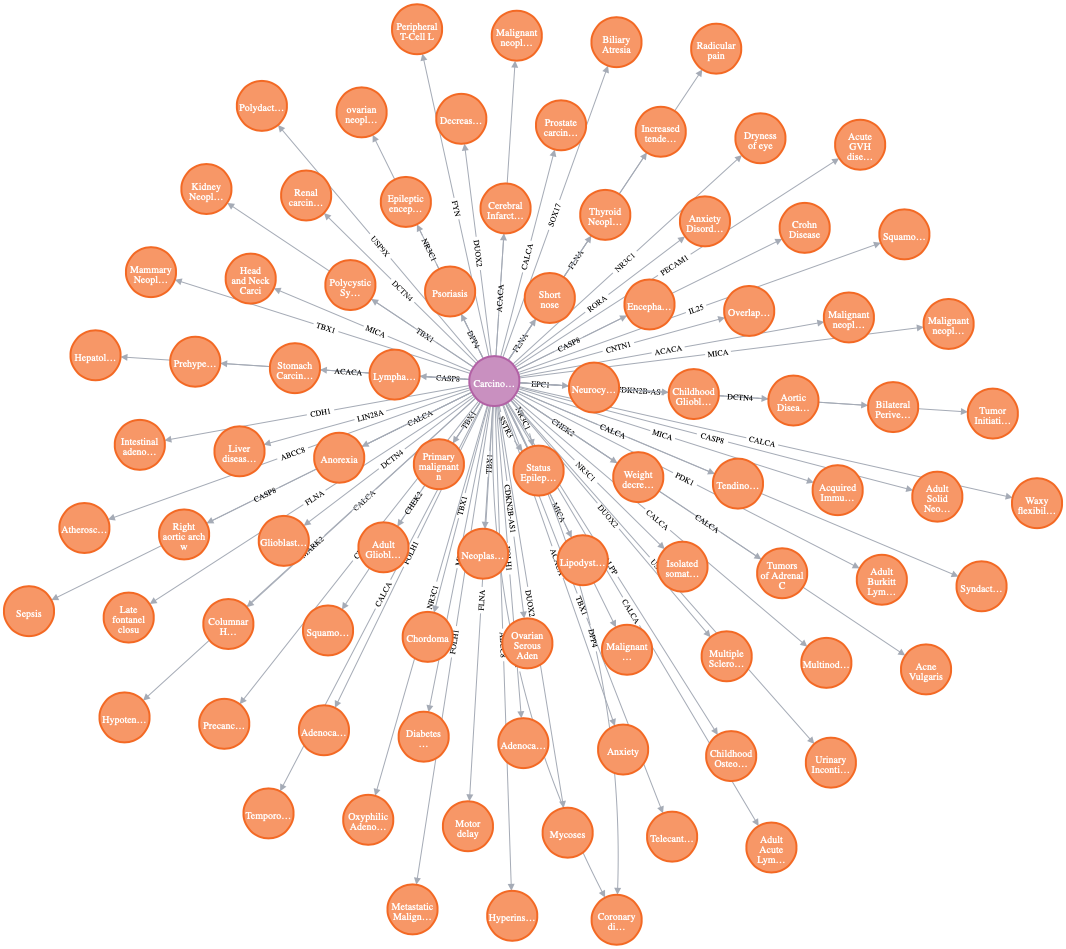

In [47]:
display(Image(os.path.join('..', 'figures', 'carc_lung.png')))

### Querying Diabetes As Disease 1

#### Overview Query

I first queried anything contained the substring 'Dia' to see what we had that included diabetes-related conditions. Of course, this query also included other conditions, but we can see distinct clusters that revealed different gene associations depending on diabetes type, as we will see.

In [ ]:
MATCH (n:DISEASE1)-[r]-() WHERE n.desc STARTS WITH 'Dia'
RETURN (n)-[r]-();

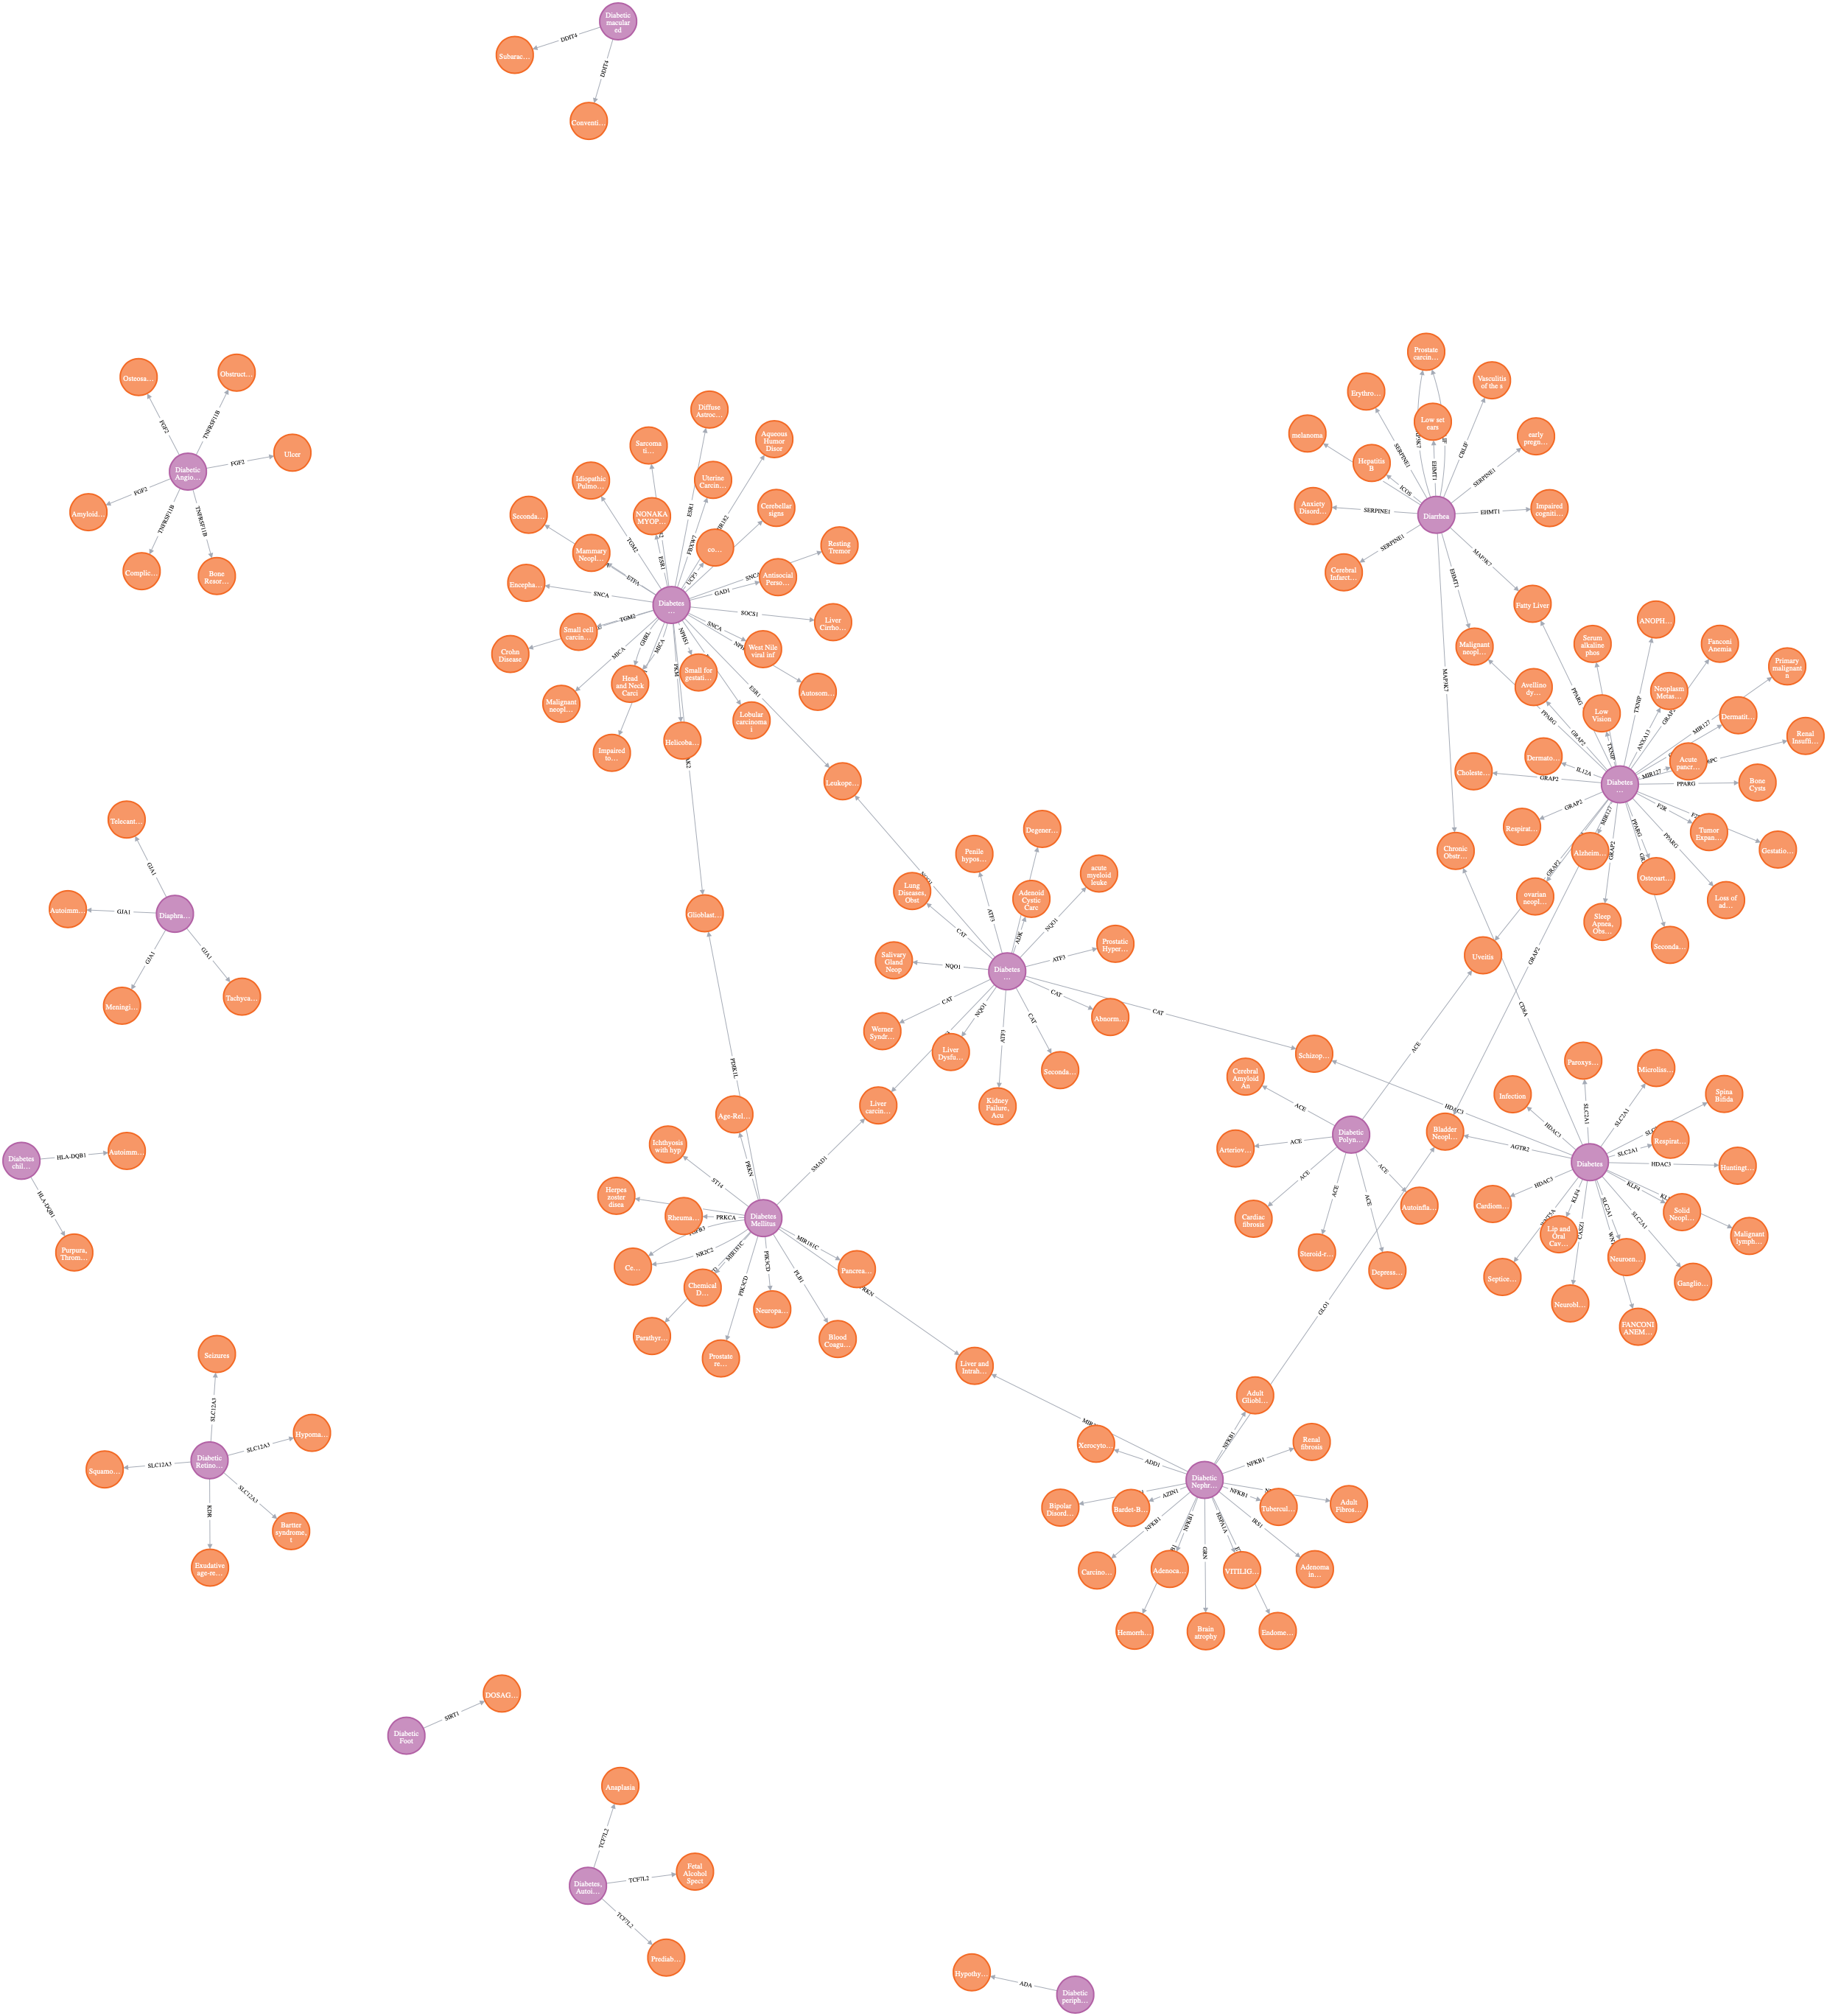

In [48]:
display(Image(os.path.join('..', 'figures', 'diabetes_disease1.png')))

#### Investigating Diabetes Mellitus Gene Associations

We can see that there are different types of diabetes mellitus conditions, including insulin-dependent (type 1) and non-insulin-dependent (type 2), that form distinct clusters with their own gene associations with different conditions. We will next investigate the gene associations with different conditions for each of the types.

In [ ]:
MATCH (n:DISEASE1)-[r]-() WHERE n.desc STARTS WITH 'Diabetes Mellitus'
RETURN (n)-[r]-();

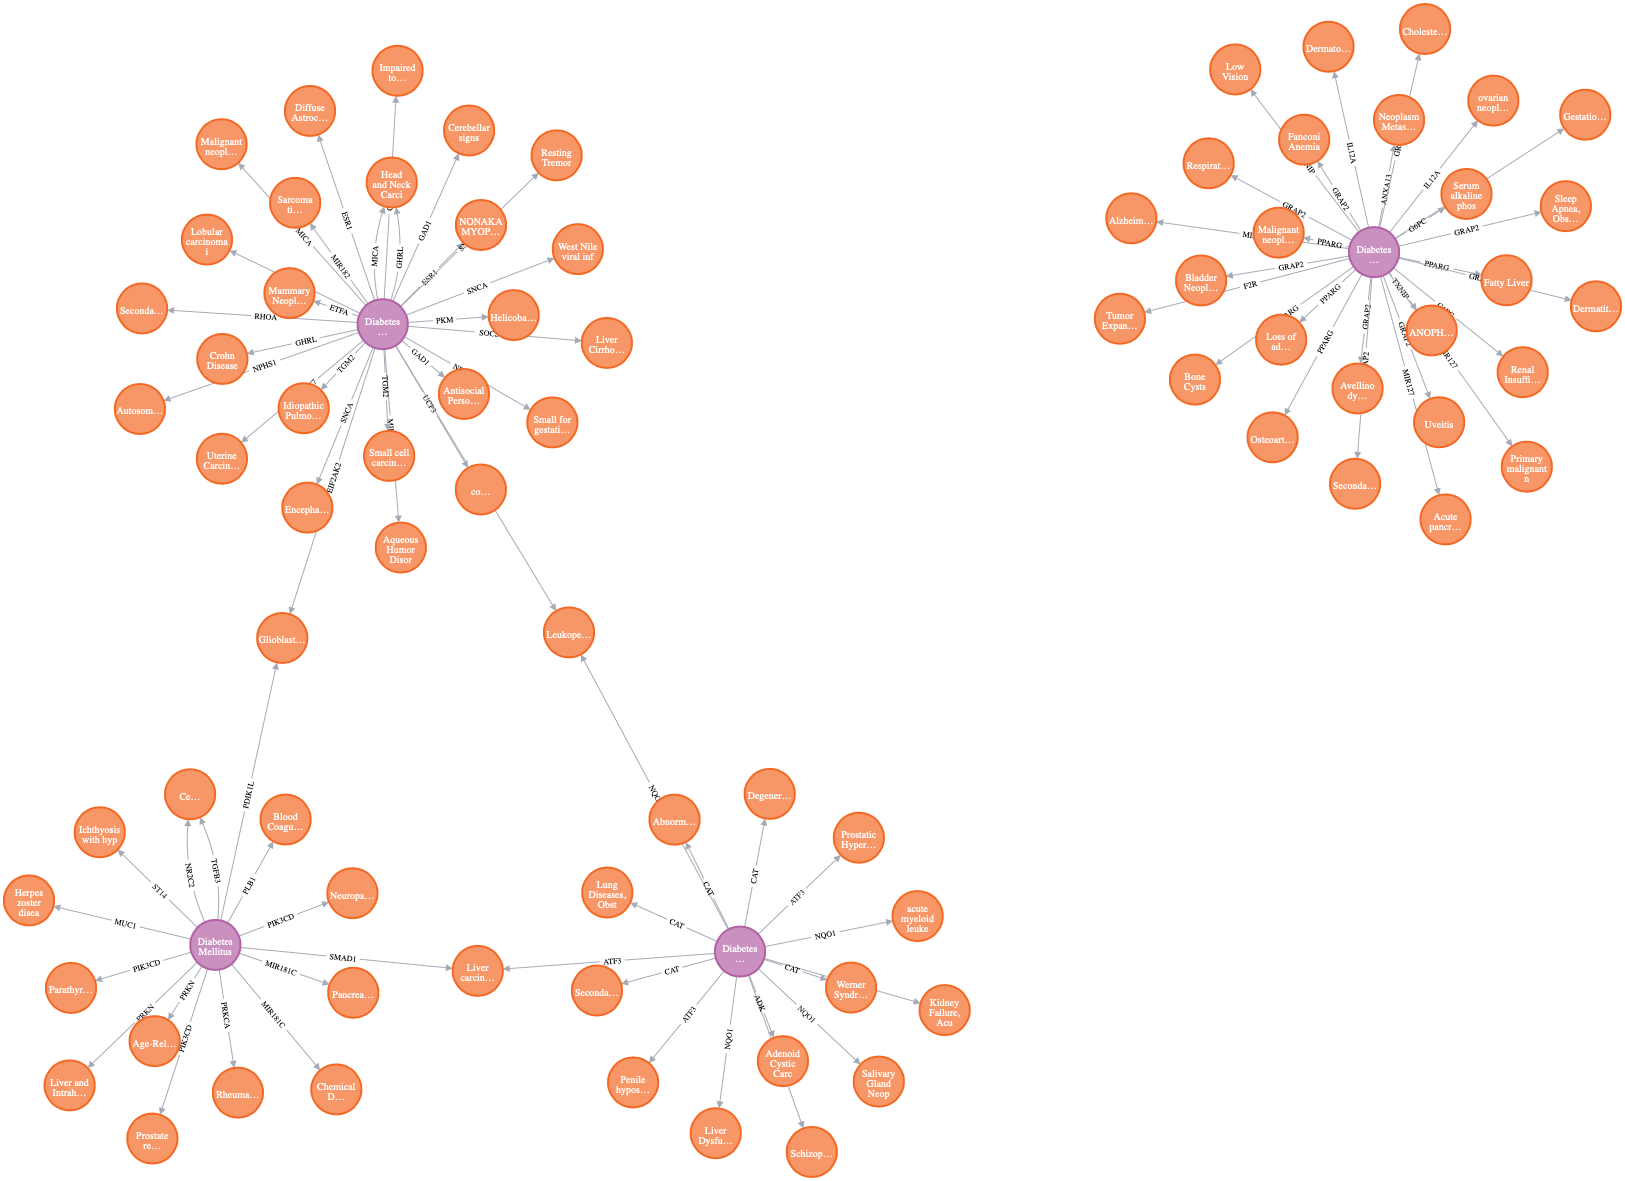

In [49]:
display(Image(os.path.join('..', 'figures', 'diabetes_overall_disease1.png')))

#### Type 1 Diabetes

Type 1 diabetes is associated with conditions such as fatty liver, bone cysts, and low vision.

In [ ]:
MATCH (n:DISEASE1)-[r]-() WHERE n.desc = 'Diabetes Mellitus, Insulin-Dependent'
RETURN (n)-[r]-();

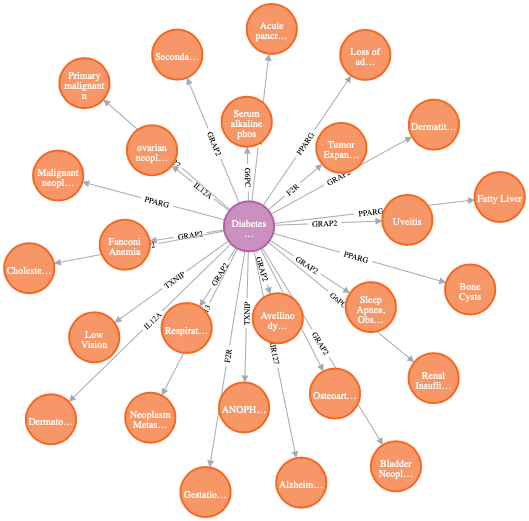

In [50]:
display(Image(os.path.join('..', 'figures', 'diabetes_type1_disease1.png')))

#### Type 2 Diabetes

Type 2 diabetes, meanwhile, is associated with Crohn Disease and restring tremor.

In [ ]:
MATCH (n:DISEASE1)-[r]-() WHERE n.desc = 'Diabetes Mellitus, Non-Insulin-Dependent'
RETURN (n)-[r]-();

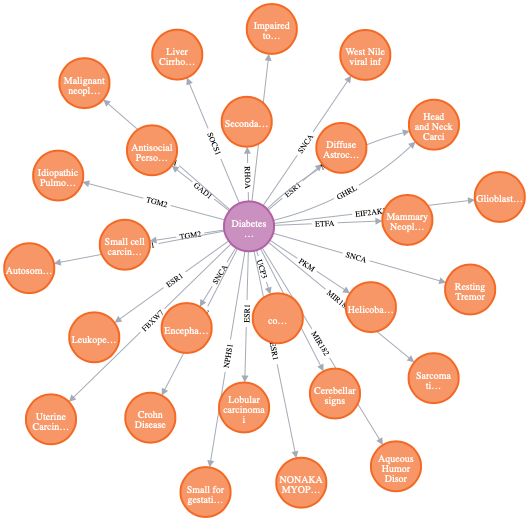

In [51]:
display(Image(os.path.join('..', 'figures', 'diabetes_type2_disease1.png')))

### Querying Diabetes As Disease 2

#### Overview

We viewed the other half of gene associations including diabetes as the second condition. Here, we see the same trend, but type 1 is not represented as the second condition, so we will compare type 2 diabetes to diabetes mellitus more generally.

In [ ]:
MATCH ()-[r]-(m:DISEASE2) WHERE m.desc STARTS WITH 'Dia'
RETURN ()-[r]-(m);

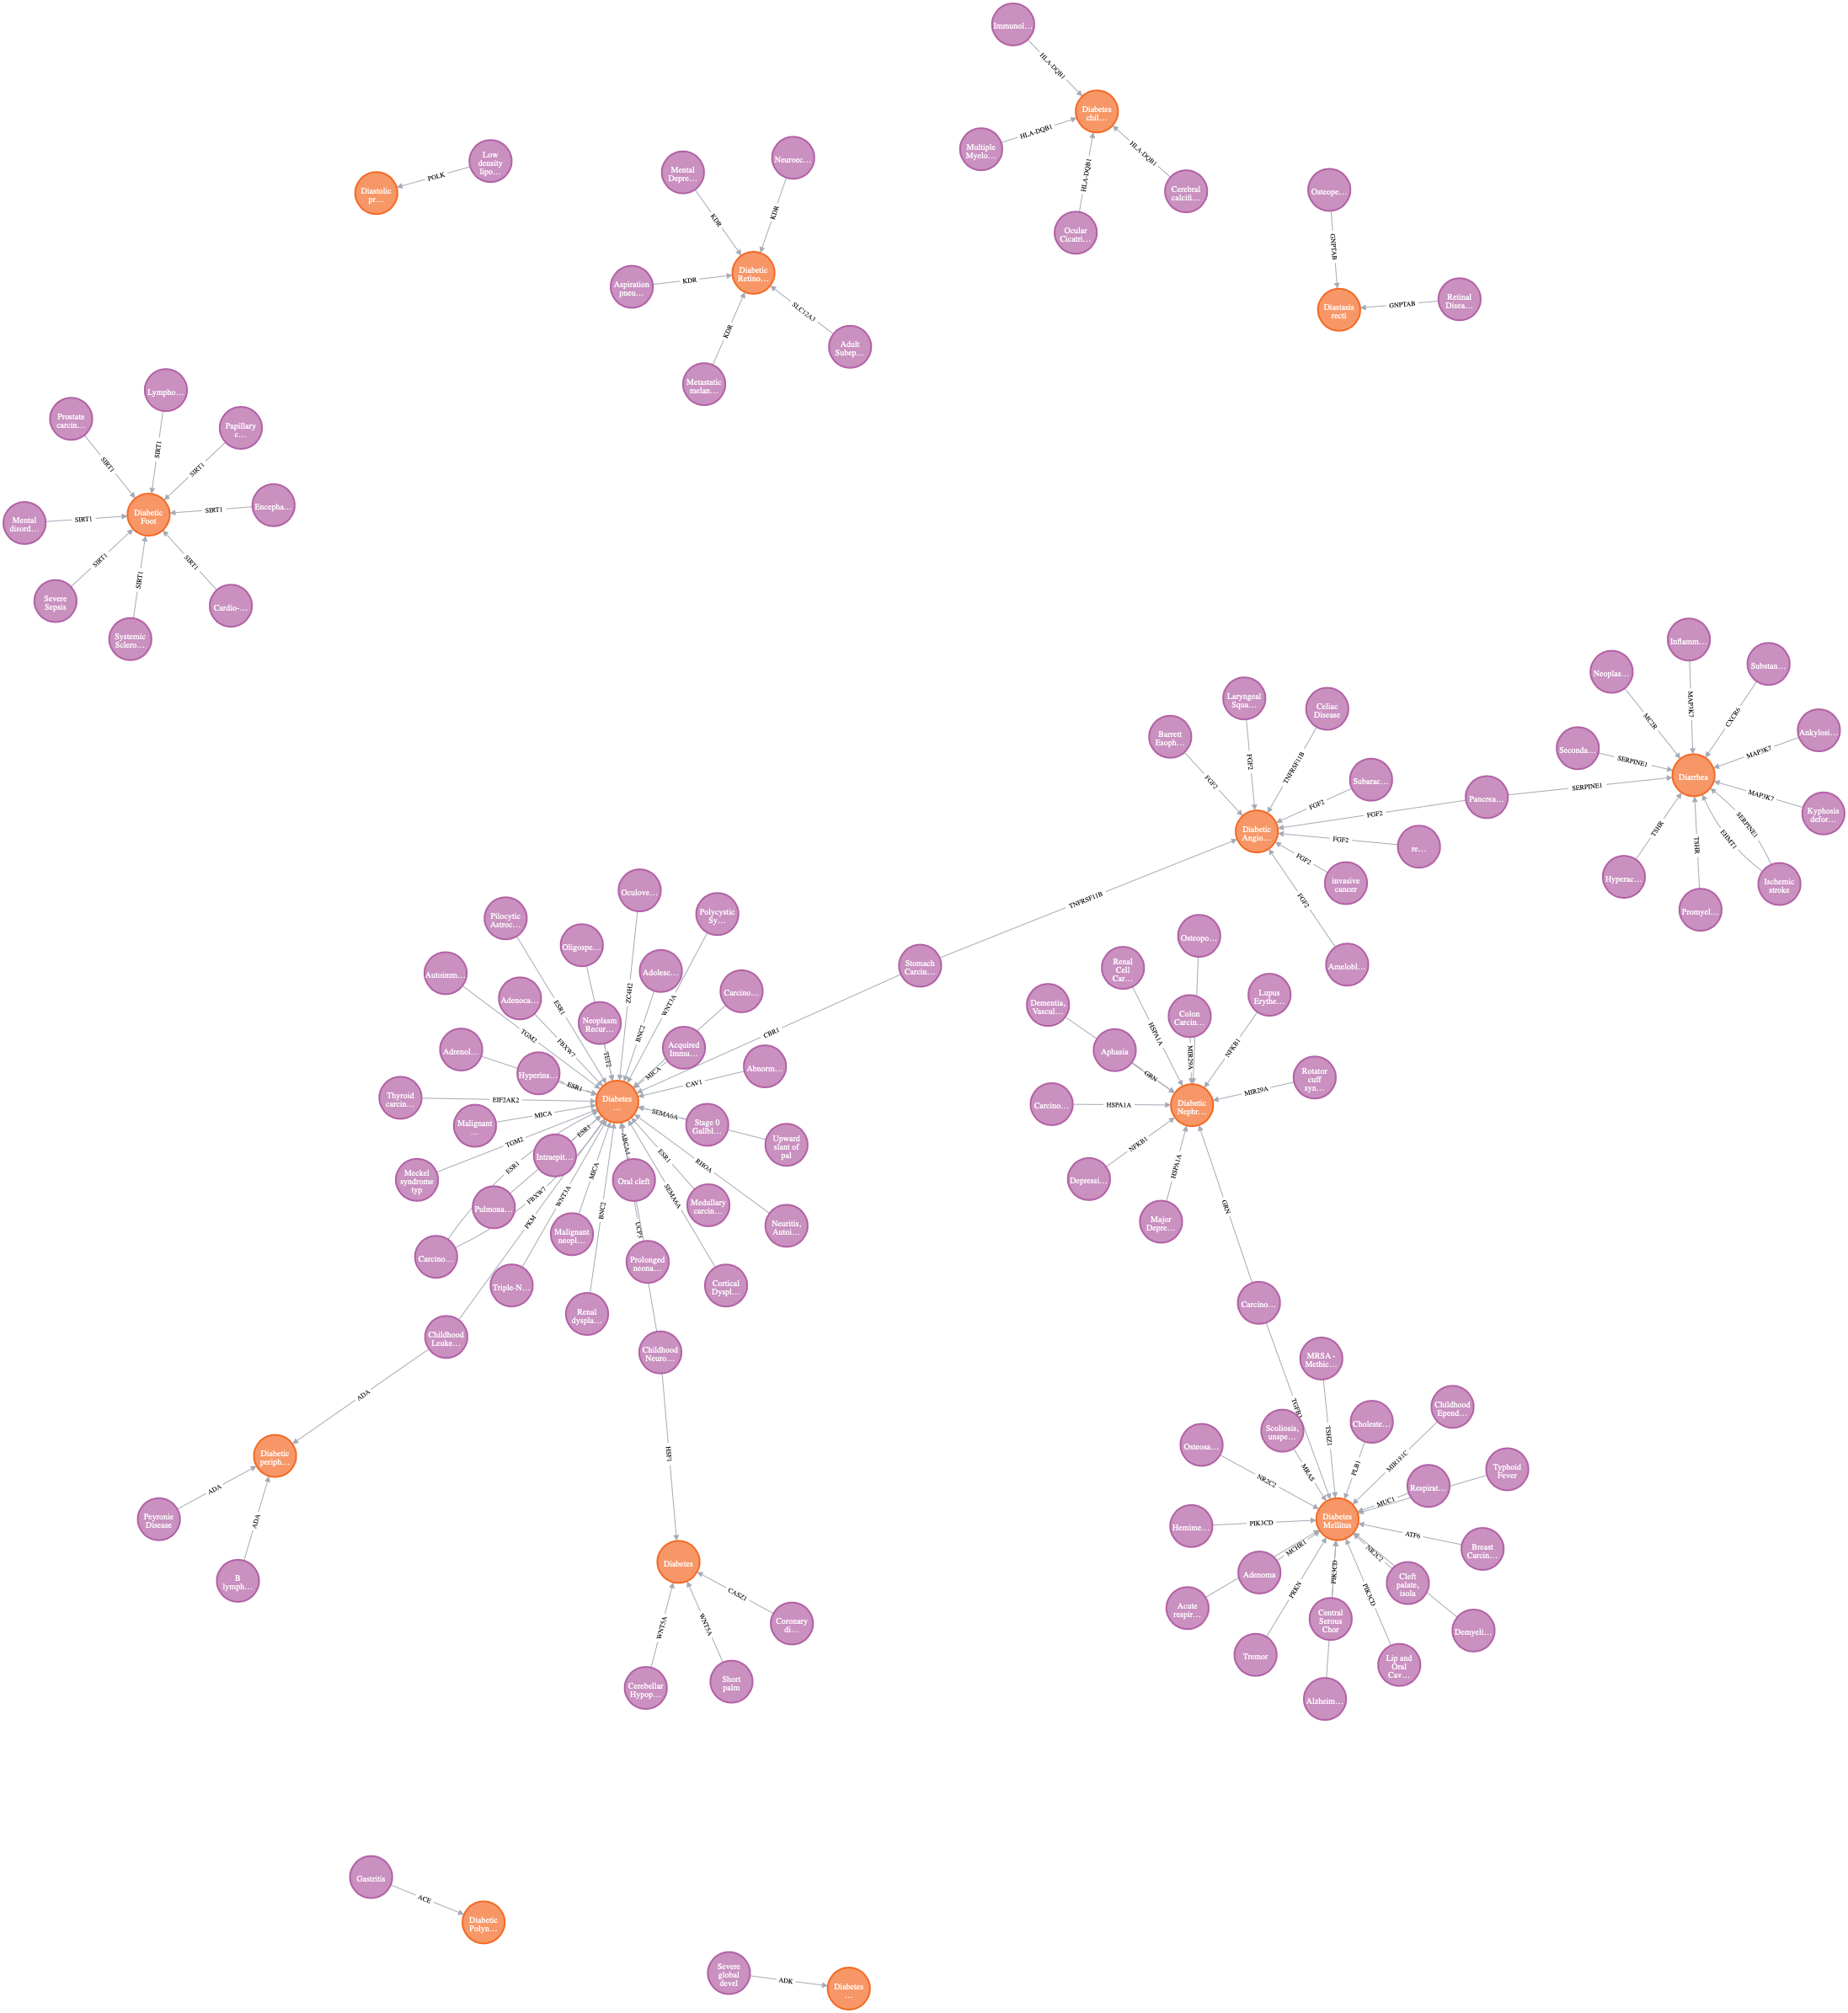

In [52]:
display(Image(os.path.join('..', 'figures', 'diabetes_disease2.png')))

#### Diabetes Mellitus

We can see that diabetes mellitus is associated with conditions such as Adenoma and Central Alzheimer's Disease.

In [ ]:
MATCH ()-[r]-(m:DISEASE2) WHERE m.desc = 'Diabetes Mellitus'
RETURN ()-[r]-(m);

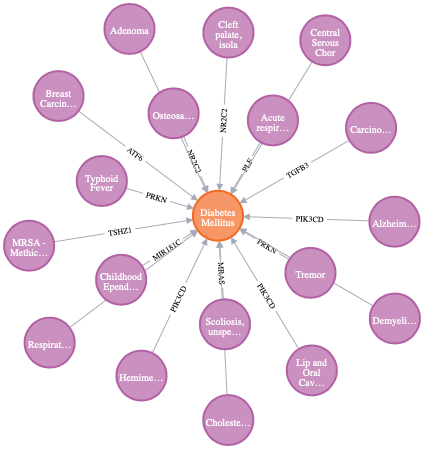

In [53]:
display(Image(os.path.join('..', 'figures', 'diabetes_type1.png')))

#### Type 2 Diabetes

Type 2 diabetes is additionally associated with oral flect and pulmonary and autoimmune disorders.

In [ ]:
MATCH ()-[r]-(m:DISEASE2) WHERE m.desc = 'Diabetes Mellitus, Non-Insulin-Dependent'
RETURN ()-[r]-(m);

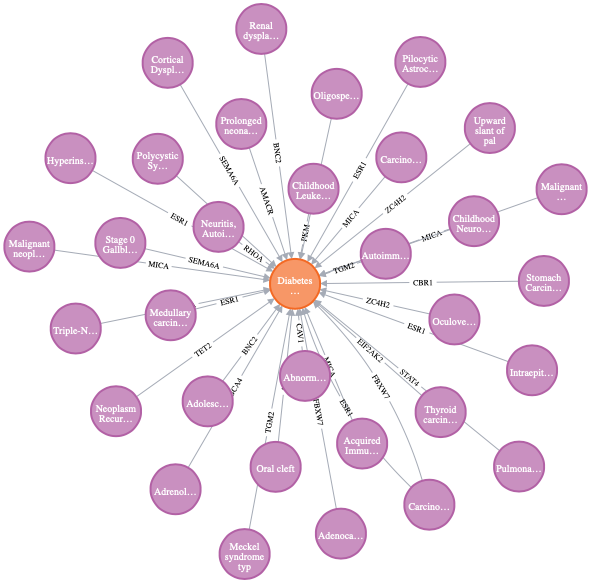

In [54]:
display(Image(os.path.join('..', 'figures', 'diabetes_type2.png')))

## Pyspark Query

I will now demonstrate how to re-create the first three queries that displayed the conditions with the most gene associations shared with other diseases, as well as the number of distinct genes that the most common condition shares and what specific genes those are as denoted by their gene symbols.

### Read in Graph as Spark Dataframe

In [55]:
# Read in graph as-is:
df = spark.read.format("org.neo4j.spark.DataSource")\
.option("url", "bolt://localhost:7687")\
.option("authentication.type", "basic")\
.option("authentication.basic.username", "neo4j")\
.option("authentication.basic.password", "Mt@pjh134!")\
.option("relationship", "SHARES_GENE_WITH")\
.option("relationship.source.labels", "DISEASE1")\
.option("relationship.target.labels", "DISEASE2")\
.load()
display(df)

DataFrame[<rel.id>: bigint, <rel.type>: string, <source.id>: bigint, <source.labels>: array<string>, source.desc: string, <target.id>: bigint, <target.labels>: array<string>, target.desc: string, rel.gene_symbol: string]

In [56]:
# Rename columns:
df = df.withColumnRenamed('<rel.type>', 'relationship')\
.withColumnRenamed('rel.gene_symbol', 'gene_symbol')\
.withColumnRenamed('source.desc', 'disease1_name')\
.withColumnRenamed('target.desc', 'disease2_name')

In [57]:
# Select only relevant columns:
df = df.select('disease1_name', 'relationship', 'gene_symbol', 'disease2_name')

In [58]:
df.show(5)

+--------------------+----------------+-----------+--------------------+
|       disease1_name|    relationship|gene_symbol|       disease2_name|
+--------------------+----------------+-----------+--------------------+
|Diabetic Nephropathy|SHARES_GENE_WITH|      NFKB1|Adenocarcinoma, T...|
|Diabetic Nephropathy|SHARES_GENE_WITH|      NFKB1|Carcinoma of urin...|
|Diabetic Nephropathy|SHARES_GENE_WITH|        GRN|       Brain atrophy|
|Diabetic Nephropathy|SHARES_GENE_WITH|       ETF1|Endometrial Carci...|
|Diabetic Nephropathy|SHARES_GENE_WITH|       IRS1|Adenoma of large ...|
+--------------------+----------------+-----------+--------------------+
only showing top 5 rows



### Queries

I first created a temp view for our graph before querying what condition shared the most gene associations with other diseases in the graph:

In [59]:
# Create temp view:
df.createOrReplaceTempView('graph')

In [60]:
# Query prevalance of disease 1 names in the graph by the non-distinct gene count:
shared_cond_query = "SELECT disease1_name, COUNT(gene_symbol) AS n_associations \
FROM graph \
GROUP BY disease1_name \
ORDER BY COUNT(gene_symbol) DESC \
LIMIT 10"

# Show results:
spark.sql(shared_cond_query).show()

+--------------------+--------------+
|       disease1_name|n_associations|
+--------------------+--------------+
|   Carcinoma of lung|            86|
|           Neoplasms|            81|
|            leukemia|            67|
|     Colon Carcinoma|            63|
|Primary malignant...|            56|
| Tumor Cell Invasion|            51|
|     Ischemic stroke|            50|
|     Atherosclerosis|            49|
|  Prostate carcinoma|            46|
| Malignant Neoplasms|            45|
+--------------------+--------------+



I next queried the count of distinct genes that the most prevalent condition (Carcinoma of lung) shares with other diseases:

In [61]:
n_shared_genes_query = "SELECT COUNT(DISTINCT(gene_symbol)) AS count FROM graph \
WHERE disease1_name = 'Carcinoma of lung'"

spark.sql(n_shared_genes_query).show()

+-----+
|count|
+-----+
|   30|
+-----+



I finally queried the name symbols of these genes:

In [62]:
gene_symbol_query = "SELECT DISTINCT(gene_symbol) AS gene_symbol FROM graph \
WHERE disease1_name = 'Carcinoma of lung'"

spark.sql(gene_symbol_query).show()

+-----------+
|gene_symbol|
+-----------+
|       MICA|
|      CNTN1|
|      CALCA|
|      USP9X|
|      FOLH1|
|       CDH1|
|      CHEK2|
|       TBX1|
|      DCTN4|
|      CASP8|
|      CRMP1|
|       FLNA|
|      SSTR3|
|      NR3C1|
|     PECAM1|
|      ABCC8|
|      ACACA|
|        FYN|
|       ALPP|
| CDKN2B-AS1|
+-----------+
only showing top 20 rows



We can see that the results match those found using Neo4j to perform the same queries.